# Load data and calculate mass loss

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------
# Load all Excel files
# ---------------------------
sim_base_path = Path("Simulated dataset") / "UniformCorrosion"
sample_files = list(sim_base_path.glob("*.xlsx"))

# Geometry
L_rod = 200  # mm
C_rod = 16   # mm
r_rod = C_rod / (2 * np.pi)
A_rod = np.pi * r_rod**2
V_rod = A_rod * L_rod

# You need the real mass of the rod (measured or density*volume)
m_rod = 300.0  # example mass in grams

def compute_mass_loss(row):
    L_cor = row['General corrosion: length of corrosion area [mm]']
    D_cor = row['General corrosion: Corrosion diameter [mm]']
    V_cor = np.pi * (D_cor/2)**2 * L_cor
    return 300-(m_rod * V_cor / V_rod)

Simulated_meta_Data = pd.read_excel("Simulated dataset\DAMAGE CASES by Kasper.xlsx")
simulated_mass_loss = compute_mass_loss(Simulated_meta_Data)
damage_locs = Simulated_meta_Data['Length from rod end [mm]'].values

# Frequency band indices
idx_low, idx_high = 70, 120

sample_weights = []
Z_meas_samples = []
damage_locations = []

for i, file in enumerate(sample_files):
    df = pd.read_excel(file)

    # Map your column names to what the pipeline expects
    f_band = df["Frequency (Hz)"].values
    Z_meas_real = df["Real (Ohm)"].values
    Z_meas_imag = df["Imaginary (Ohm)"].values

    # Complex impedance
    Z_meas_band = Z_meas_real + 1j * Z_meas_imag

    # Restrict to frequency band
    f_fit = f_band[idx_low:idx_high]
    Z_meas_fit = Z_meas_band[idx_low:idx_high]
    sample_weight = simulated_mass_loss[i]  

    sample_weights.append(sample_weight)
    Z_meas_samples.append(Z_meas_fit)
    damage_locations.append(damage_locs[i])


print(f"Loaded", len(sample_files), "samples")
print(f"Z_meas_samples[0] shape:", Z_meas_samples[0].shape)

<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
C:\Users\au585732\AppData\Local\Temp\ipykernel_7796\3400952937.py:28: SyntaxWarning: invalid escape sequence '\D'
  Simulated_meta_Data = pd.read_excel("Simulated dataset\DAMAGE CASES by Kasper.xlsx")


Loaded 27 samples
Z_meas_samples[0] shape: (50,)


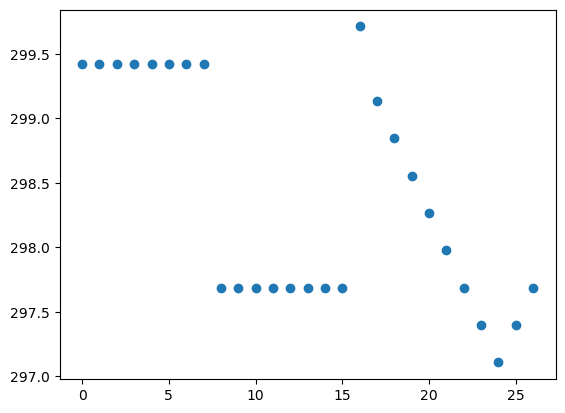

In [2]:
damage_loc_amount = np.array(damage_locations)*np.array(sample_weights)
plt.plot(sample_weights, 'o')

c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


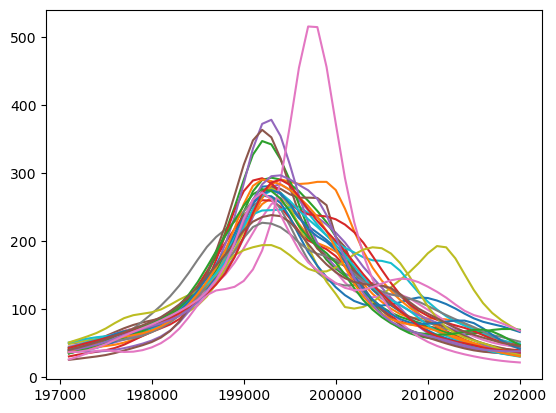

In [3]:
for data in Z_meas_samples:
    plt.plot(f_fit, data)

## Functions for fitting

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- generalized N-DOF BVD model ---
def NDOF_bvd_theta(f, theta):
    n = len(theta) // 4
    w = 2*np.pi*f
    Y_total = np.zeros_like(f, dtype=complex)

    for i in range(n):
        fs, Q, Cm, C0 = theta[i*4:(i+1)*4]
        R, L, C, C0 = RLC_from_fsQCm(fs, Q, Cm, C0)
        Z = R + 1j*w*L + 1/(1j*w*C)
        Y = 1j*w*C0 + 1/Z
        Y_total += Y

    return 1.0 / Y_total

# --- cost function for differential_evolution ---
def bvd_cost(theta, f, Z_meas):
    Z_model = NDOF_bvd_theta(f, theta)
    # weighted sum of squared errors (real + imag)
    err = np.abs(Z_model.real - Z_meas.real)**2 + np.abs(Z_model.imag - Z_meas.imag)**2
    return np.sum(err)

## Constants for main loop ---------

In [5]:
# -------------------------
# measured data
f_fit = f_fit
Z_meas = Z_meas_fit

# -------------------------
# Set start values arbitrary number of BVD resonators
R_list = [55.7, 20.0, 20.04]
L_list = [0.0033, 0.0031, 0.00319]
C_list = [1.99e-10, 2.511e-10, 2.511e-1]
C0_list = [2.9e-09, 2.5e-09, 2.5e-09]

# -------------------------
# Constants
fs_pad = 0.15
drift = 0.20  # allow ±5% drift around previous fit



Initial theta used in NDOF_bvd_theta: [196397.8022069413, 73.1097395174821, 1.99e-10, 2.9e-09, 180391.44123472055, 175.68209223157663, 2.511e-10, 2.5e-09, 5.62343181677323, 0.005624374984679226, 0.2511, 2.5e-09]


c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


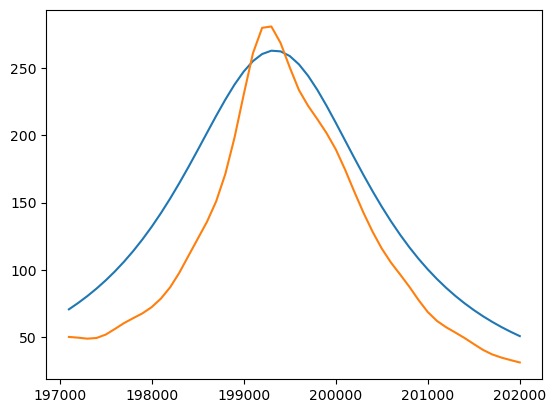

In [6]:
initial_theta = []; bounds = []; all_fits = []; all_z_fits = []

# -------------------------
# Set start values arbitrary number of BVD resonators
R_list = [55.7, 20.0, 20.04]
L_list = [0.0033, 0.0031, 0.00319]
C_list = [1.99e-10, 2.511e-10, 2.511e-1]
C0_list = [2.9e-09, 2.5e-09, 2.5e-09]



for R, L, C, C0 in zip(R_list, L_list, C_list, C0_list):
    fs_guess, Q_guess, Cm_guess, C0_guess = bvd_from_RLC(R, L, C, C0)
    initial_theta.extend([fs_guess, Q_guess, Cm_guess, C0_guess])
    bounds.extend([
        ((1-fs_pad)*fs_guess, (1+fs_pad)*fs_guess),
        (1e-1, 1e5),
        (Cm_guess*1e-3, Cm_guess*1e3),
        (C0_guess*1e-3, C0_guess*1e3)
    ])

test_bvd = NDOF_bvd_theta(f_fit, initial_theta)

plt.plot(f_fit, test_bvd.real, label='Initial BVD real')
plt.plot(f_fit, Z_meas_samples[0], label='Measured real')
print("Initial theta used in NDOF_bvd_theta:", initial_theta)

## ---------Main for loop------------

In [7]:
import time

# -------------------------
# Data holders
initial_theta = []; bounds = []; all_fits = []; all_z_fits = []

# Loop over all datasets
for q, dataset in enumerate(Z_meas_samples):
    if q == 0:
        # First dataset: use guesses from R, L, C, C0
        initial_theta = []
        bounds = []
        for R, L, C, C0 in zip(R_list, L_list, C_list, C0_list):
            fs_guess, Q_guess, Cm_guess, C0_guess = bvd_from_RLC(R, L, C, C0)
            initial_theta.extend([fs_guess, Q_guess, Cm_guess, C0_guess])
            bounds.extend([
                ((1-fs_pad)*fs_guess, (1+fs_pad)*fs_guess),
                (1e-1, 1e5),
                (Cm_guess*1e-3, Cm_guess*1e3),
                (C0_guess*1e-3, C0_guess*1e3)
            ])
    else:
        # Later datasets: use the previous fit as baseline
        prev_theta = all_fits[-1]  # <-- progressive drift
        bounds = []
        drift_frac = drift  # allow ±5% drift around previous fit
        for val in prev_theta:
            delta = drift_frac * abs(val) if val != 0 else drift_frac
            lower = val - delta
            upper = val + delta
            bounds.append((lower, upper))
        initial_theta = list(prev_theta)  # not used by DE but kept for clarity

    # Run DE --------------------------------
    result_de = differential_evolution(
        bvd_cost,
        bounds=bounds,
        args=(f_fit, dataset),
        strategy='best1bin',
        maxiter=500,
        popsize=20,
        tol=0,
        polish=False,
        disp=True
    )

    theta_fit = result_de.x
    all_fits.append(theta_fit)

    print("\nDifferential Evolution Result:")
    n_resonators = len(theta_fit)//4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = theta_fit[i*4:(i+1)*4]
        print(f"  Resonator {i+1}: fs={fs:.3f}, Q={Q:.3f}, Cm={Cm:.3e}, C0={C0:.3e}")

    # Evaluate fitted model
    Z_fit = NDOF_bvd_theta(f_fit, theta_fit)
    all_z_fits.append(Z_fit)
    print(f"q={q}, before append: len(all_fits)={len(all_fits)}, len(all_z_fits)={len(all_z_fits)}")
    time.sleep(2)


differential_evolution step 1: f(x)= 1429475.0465870148
differential_evolution step 2: f(x)= 1429475.0465870148
differential_evolution step 3: f(x)= 1429475.0465870148
differential_evolution step 4: f(x)= 1429475.0465870148
differential_evolution step 5: f(x)= 1429475.0465870148
differential_evolution step 6: f(x)= 1429475.0465870148
differential_evolution step 7: f(x)= 1429475.0465870148
differential_evolution step 8: f(x)= 1429475.0465870148
differential_evolution step 9: f(x)= 1415438.4651418729
differential_evolution step 10: f(x)= 1415438.4651418729
differential_evolution step 11: f(x)= 1415438.4651418729
differential_evolution step 12: f(x)= 1415438.4651418729
differential_evolution step 13: f(x)= 1415438.4651418729
differential_evolution step 14: f(x)= 1415438.4651418729
differential_evolution step 15: f(x)= 1415438.4651418729
differential_evolution step 16: f(x)= 1415438.4651418729
differential_evolution step 17: f(x)= 1415438.4651418729
differential_evolution step 18: f(x)= 14

KeyboardInterrupt: 

## Save data to pickle

In [8]:
import pickle

with open("Fitted datasets/Simulated-fits-drift-10-pop-2pkl", "wb") as f:
    pickle.dump({"all_fits": all_fits, "all_z_fits": all_z_fits}, f)

## Load data

In [9]:
import pickle

with open("Fitted datasets/Simulated-fits-drift-10-pop-20-maxiter-500.pkl", "rb") as f:
    data = pickle.load(f)

all_fits = data["all_fits"]
all_z_fits = data["all_z_fits"]

In [10]:
len(all_fits), len(all_z_fits)

(27, 27)

# Analyse data

     Mean_Mass
0     0.000000
1   -18.930219
2   -58.981976
3  -121.704478
4  -152.610669
5  -107.292406
6   -75.307421
7   -66.403833
8  -112.975154
9   -65.119672
10  -37.825163
11  -45.505471
12  -38.863217
13  -60.594646
14  -67.591089
15  -64.725152
16  -88.551850
17  -61.642465
18  -84.879960
19  -82.747177
20  -75.354068
21  -82.240675
22  -97.267031
23 -103.104948
24  -86.290218
25  -86.600592
26 -114.823500


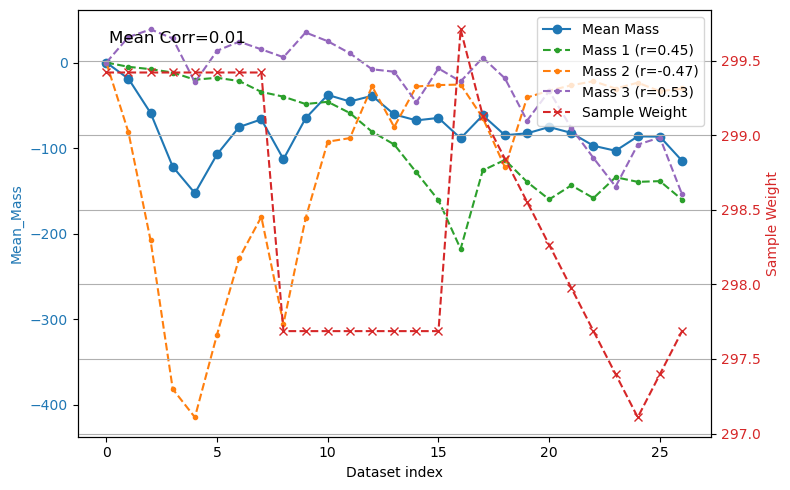

In [11]:
import pandas as pd
import pickle
import numpy as np
from scipy.stats import pearsonr

# # Load fits
# with open("Fitted datasets\Sample4fits-drift-10-pop-20-maxiter-1000.pkl", "rb") as f:
#     data = pickle.load(f)

# all_fits = data["all_fits"]

# Build DataFrame
param_types = ["fs", "Q", "Cm", "C0"]
records = []

for fit in all_fits:
    rec = {}
    n_resonators = len(fit) // 4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"] = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# Compute mean motional mass per dataset
m_ref = 150  # 1 ng
fs_cols = [c for c in df.columns if c.startswith("fs")]

mass_per_dataset = []

for idx, row in df.iterrows():
    masses = []
    for fs_col in fs_cols:
        f_ref = df.loc[0, fs_col]   # reference frequency
        f_cur = row[fs_col]
        if f_cur > 0 and f_ref > 0:
            m = m_ref * (f_ref / f_cur)**2
            masses.append(m)
    if masses:
        mass_per_dataset.append(np.mean(masses))
    else:
        mass_per_dataset.append(np.nan)

df["Mean_Mass"] = mass_per_dataset

# Compute mass for each resonator
for i, fs_col in enumerate(fs_cols):
    df[f"Mass_{i+1}"] = m_ref * (df.loc[0, fs_col] / df[fs_col])**2

print(m_ref - df[["Mean_Mass"]])

fig, ax1 = plt.subplots(figsize=(8,5))

color1 = 'tab:blue'
ax1.set_xlabel('Dataset index')
ax1.set_ylabel('Mean_Mass', color=color1)
ax1.plot(m_ref - df["Mean_Mass"], marker='o', color=color1, label='Mean Mass')

# Plot individual resonator masses and compute correlations
colors = ['tab:green', 'tab:orange', 'tab:purple']
mass_corrs = []
for i, mass_col in enumerate([f"Mass_{j+1}" for j in range(len(fs_cols))]):
    corr_i, _ = pearsonr(m_ref - df[mass_col], sample_weights)
    mass_corrs.append(corr_i)
    ax1.plot(m_ref - df[mass_col], marker='.', linestyle='--', color=colors[i],
             label=f'Mass {i+1} (r={corr_i:.2f})')

ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Sample Weight', color=color2)
ax2.plot(sample_weights, marker='x', linestyle='--', color=color2, label='Sample Weight')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.grid(True)

# Correlation indicator (Pearson r) between mean mass loss and sample weight
corr, _ = pearsonr(m_ref - df["Mean_Mass"], sample_weights)
ax1.text(0.05, 0.95, f'Mean Corr={corr:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper right')
plt.show()



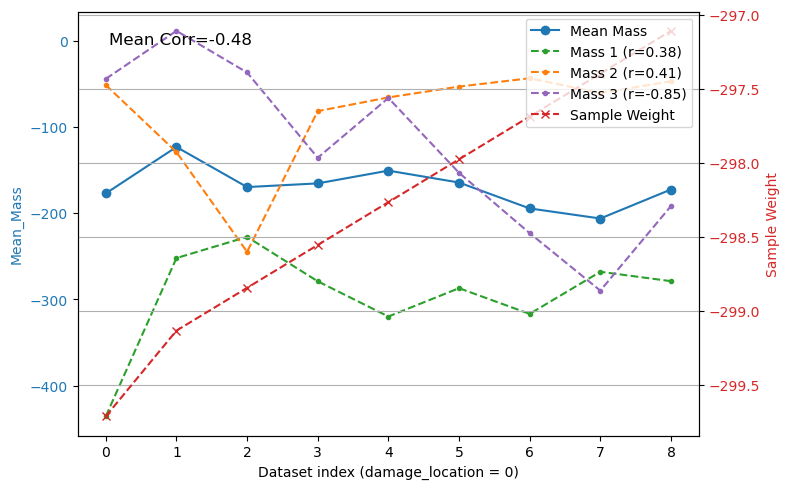

In [12]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example: load your fits (uncomment in your case)
# with open("Fitted datasets/Sample4fits-drift-10-pop-20-maxiter-1000.pkl", "rb") as f:
#     data = pickle.load(f)
# all_fits = data["all_fits"]

# --- Build DataFrame ---
param_types = ["fs", "Q", "Cm", "C0"]
records = []

for fit in all_fits:
    rec = {}
    n_resonators = len(fit) // 4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"] = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# --- Compute mean motional mass per dataset ---
m_ref = 300  # 1 ng
fs_cols = [c for c in df.columns if c.startswith("fs")]

mass_per_dataset = []
for idx, row in df.iterrows():
    masses = []
    for fs_col in fs_cols:
        f_ref = df.loc[0, fs_col]   # reference frequency
        f_cur = row[fs_col]
        if f_cur > 0 and f_ref > 0:
            m = m_ref * (f_ref / f_cur)**2
            masses.append(m)
    if masses:
        mass_per_dataset.append(np.mean(masses))
    else:
        mass_per_dataset.append(np.nan)

df["Mean_Mass"] = mass_per_dataset

# --- Compute per-resonator masses ---
for i, fs_col in enumerate(fs_cols):
    df[f"Mass_{i+1}"] = m_ref * (df.loc[0, fs_col] / df[fs_col])**2

# --- Filter to only damage_location == 0 ---
damage_locations = np.array([ 5,10,15,20,25,30,35,40,
                               5,10,15,20,25,30,35,40,
                               0,0,0,0,0,0,0,0,0,
                               5,10])   # <- your array

mask = (damage_locations == 0)
df = df.loc[mask].reset_index(drop=True)
sample_weights_filtered = np.array(sample_weights)[mask]

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(8,5))

color1 = 'tab:blue'
ax1.set_xlabel('Dataset index (damage_location = 0)')
ax1.set_ylabel('Mean_Mass', color=color1)
ax1.plot(m_ref - df["Mean_Mass"], marker='o', color=color1, label='Mean Mass')

# Plot individual resonator masses and correlations
colors = ['tab:green', 'tab:orange', 'tab:purple']
mass_corrs = []
for i, mass_col in enumerate([f"Mass_{j+1}" for j in range(len(fs_cols))]):
    corr_i, _ = pearsonr(m_ref - df[mass_col], -sample_weights_filtered)
    mass_corrs.append(corr_i)
    ax1.plot(m_ref - df[mass_col], marker='.', linestyle='--', color=colors[i % len(colors)],
             label=f'Mass {i+1} (r={corr_i:.2f})')

ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Sample Weight', color=color2)
ax2.plot(-sample_weights_filtered, marker='x', linestyle='--', color=color2, label='Sample Weight')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.grid(True)

# Correlation indicator
corr, _ = pearsonr(m_ref - df["Mean_Mass"], -sample_weights_filtered)
ax1.text(0.05, 0.95, f'Mean Corr={corr:.2f}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', color='black')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper right')
plt.show()


[ 5 10 15 20 25 30 35 40  5 10 15 20 25 30 35 40  0  0  0  0  0  0  0  0
  0  5 10]


c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


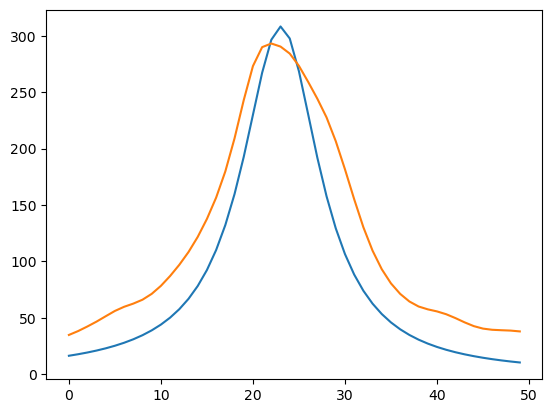

In [13]:
print(np.array(damage_locations))
plt.plot(all_z_fits[2])
plt.plot(Z_meas_samples[2])

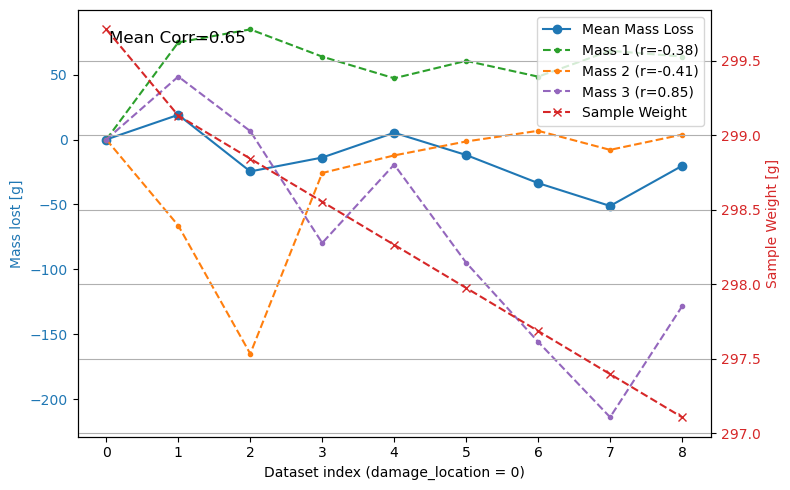

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -----------------------------
# Parameters
# -----------------------------
m_ref = 300.0  # rod mass in grams


# Filter only datasets where damage_location == 0
mask = (damage_locations == 0)
all_fits_filtered = [fit for fit, keep in zip(all_fits, mask) if keep]
sample_weights_filtered = np.array(sample_weights)[mask]

# -----------------------------
# Build DataFrame
# -----------------------------
records = []
for fit in all_fits_filtered:
    rec = {}
    n_resonators = len(fit) // 4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"] = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)
fs_cols = [c for c in df.columns if c.startswith("fs")]

# -----------------------------
# Compute mass for each resonator
# -----------------------------
for i, fs_col in enumerate(fs_cols):
    f_ref = df.loc[0, fs_col]  # reference freq from first undamaged dataset
    df[f"Mass_{i+1}"] = m_ref * (f_ref / df[fs_col])**2

# Compute mean mass loss
df["Mean_Mass"] = df[[f"Mass_{i+1}" for i in range(len(fs_cols))]].mean(axis=1)

# -----------------------------
# Plot
# -----------------------------
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot mean mass loss
color1 = 'tab:blue'
ax1.set_xlabel('Dataset index (damage_location = 0)')
ax1.set_ylabel('Mass lost [g]', color=color1)
ax1.plot(m_ref - df["Mean_Mass"], marker='o', color=color1, label='Mean Mass Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Plot individual resonator mass losses
colors = ['tab:green', 'tab:orange', 'tab:purple']
for i, mass_col in enumerate([f"Mass_{j+1}" for j in range(len(fs_cols))]):
    corr_i, _ = pearsonr(m_ref - df[mass_col], sample_weights_filtered)
    ax1.plot(m_ref - df[mass_col], marker='.', linestyle='--', color=colors[i % len(colors)],
             label=f'Mass {i+1} (r={corr_i:.2f})')

# Plot sample weights
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Sample Weight [g]', color=color2)
ax2.plot(sample_weights_filtered, marker='x', linestyle='--', color=color2, label='Sample Weight')
ax2.tick_params(axis='y', labelcolor=color2)

# Correlation indicator for mean mass loss
corr, _ = pearsonr(m_ref - df["Mean_Mass"], sample_weights_filtered)
ax1.text(0.05, 0.95, f'Mean Corr={corr:.2f}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', color='black')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


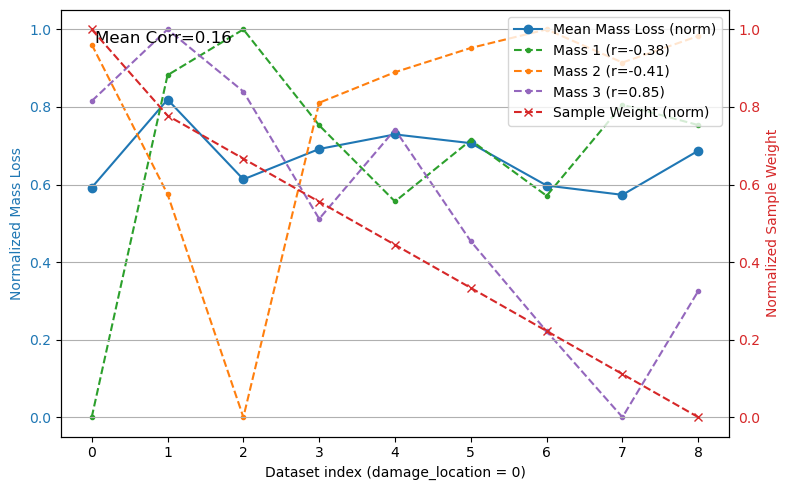

In [15]:
from scipy.stats import zscore

# -----------------------------
# Normalize data
# -----------------------------
# Mass losses
mass_cols = [f"Mass_{i+1}" for i in range(len(fs_cols))]
mass_loss = m_ref - df[mass_cols]  # predicted mass loss
mass_loss_norm = (mass_loss - mass_loss.min()) / (mass_loss.max() - mass_loss.min())

# Sample weights
sample_weights_norm = (sample_weights_filtered - sample_weights_filtered.min()) / \
                      (sample_weights_filtered.max() - sample_weights_filtered.min())
# -----------------------------
# Plot normalized data
# -----------------------------
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot mean normalized mass loss
mean_mass_loss_norm = mass_loss_norm.mean(axis=1)
color1 = 'tab:blue'
ax1.set_xlabel('Dataset index (damage_location = 0)')
ax1.set_ylabel('Normalized Mass Loss', color=color1)
ax1.plot(mean_mass_loss_norm, marker='o', color=color1, label='Mean Mass Loss (norm)')
ax1.tick_params(axis='y', labelcolor=color1)

# Plot individual resonator normalized mass losses
colors = ['tab:green', 'tab:orange', 'tab:purple']
for i, mass_col in enumerate(mass_loss_norm.columns):
    corr_i, _ = pearsonr(mass_loss_norm[mass_col], sample_weights_norm)
    ax1.plot(mass_loss_norm[mass_col], marker='.', linestyle='--', color=colors[i % len(colors)],
             label=f'Mass {i+1} (r={corr_i:.2f})')

# Plot normalized sample weights
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Normalized Sample Weight', color=color2)
ax2.plot(sample_weights_norm, marker='x', linestyle='--', color=color2, label='Sample Weight (norm)')
ax2.tick_params(axis='y', labelcolor=color2)

# Correlation indicator for mean mass loss
corr, _ = pearsonr(mean_mass_loss_norm, sample_weights_norm)
ax1.text(0.05, 0.95, f'Mean Corr={corr:.2f}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', color='black')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


Correlation of Resonator 3 parameters with sample weights:
fs1: r = -0.323, p = 0.397
fs2: r = -0.433, p = 0.245
fs3: r = 0.845, p = 0.004
Q1: r = -0.133, p = 0.732
Q2: r = 0.950, p = 0.000
Q3: r = 0.357, p = 0.346
Cm1: r = 0.196, p = 0.613
Cm2: r = 0.328, p = 0.388
Cm3: r = -0.677, p = 0.045
C01: r = 0.883, p = 0.002
C02: r = 0.461, p = 0.212
C03: r = -0.822, p = 0.007


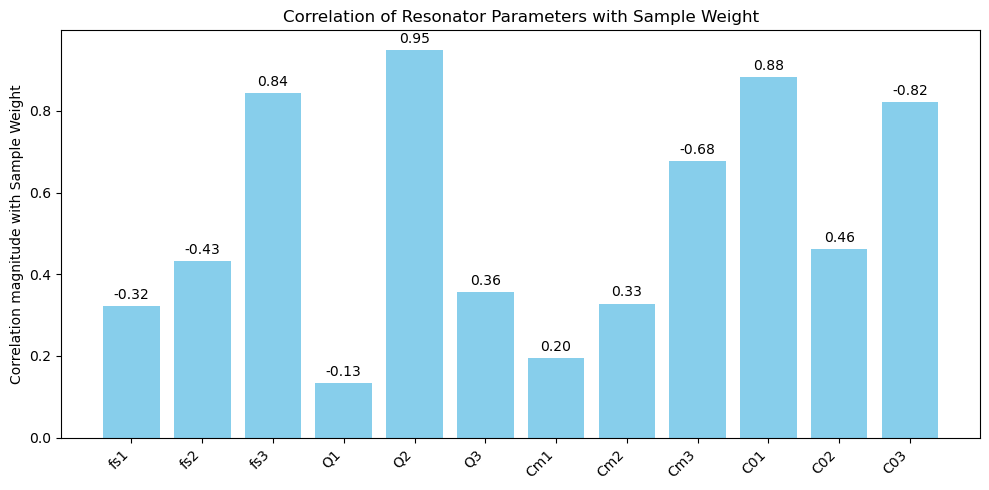

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Assume df already contains the filtered datasets (damage_location == 0)
# and sample_weights_filtered is the corresponding array of rod masses

# Columns for resonator 3
res3_cols = ["fs3", "Q3", "Cm3", "C03", "fs1", "fs2", "Q1", "Q2", "Cm1", "Cm2", "C01", "C02"]
res3_cols = ["fs1", "fs2", "fs3", "Q1", "Q2", "Q3", "Cm1", "Cm2", "Cm3", "C01", "C02", "C03"]

print("Correlation of Resonator 3 parameters with sample weights:")
for col in res3_cols:
    corr, pval = pearsonr(df[col], sample_weights_filtered)
    print(f"{col}: r = {corr:.3f}, p = {pval:.3f}")


import matplotlib.pyplot as plt

# Compute correlations
corr_values = []
corr_signs = []
for col in res3_cols:
    corr, _ = pearsonr(df[col], sample_weights_filtered)
    corr_values.append(abs(corr))       # bar height = absolute value
    corr_signs.append("-" if corr < 0 else "")  # track original sign

# Create bar plot
plt.figure(figsize=(10,5))
bars = plt.bar(res3_cols, corr_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation magnitude with Sample Weight')
plt.title('Correlation of Resonator Parameters with Sample Weight')

# Add correlation value labels on top of bars with minus if originally negative
for bar, corr, sign in zip(bars, corr_values, corr_signs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{sign}{corr:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


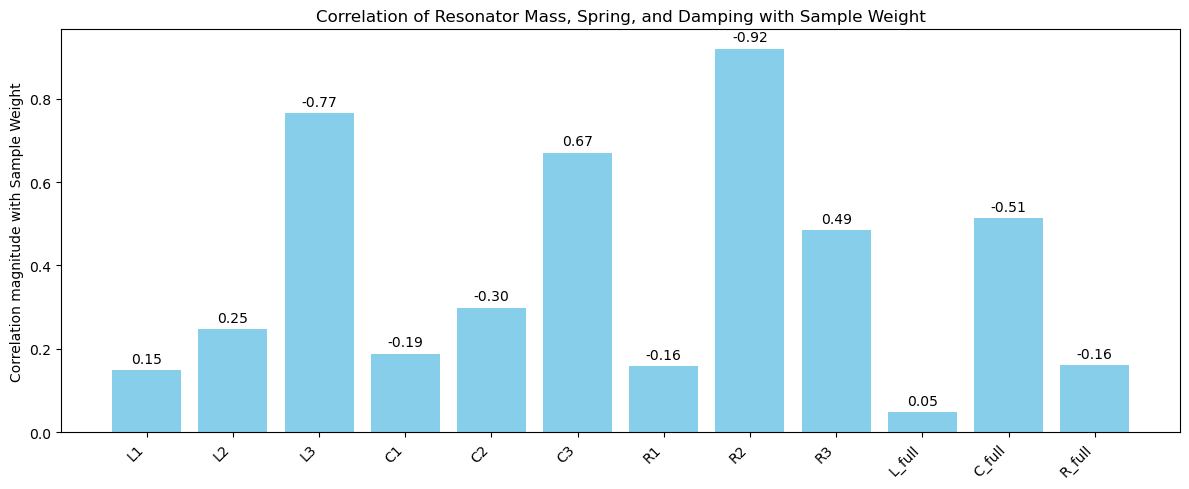

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

n_res = len(fs_cols)  # number of resonators (e.g., 3)
mass_cols = []
spring_cols = []
damping_cols = []

for i in range(n_res):
    fs = df[f"fs{i+1}"].values
    Q = df[f"Q{i+1}"].values
    Cm = df[f"Cm{i+1}"].values
    C0 = df[f"C0{i+1}"].values
    
    # Motional mass
    L_eq = 1 / ((2 * np.pi * fs)**2 * Cm)
    df[f"L{i+1}"] = L_eq
    mass_cols.append(f"L{i+1}")
    
    # Motional spring
    K_eq = 1 / Cm
    df[f"C{i+1}"] = K_eq
    spring_cols.append(f"C{i+1}")
    
    # Damping
    R_eq = fs / (Q * Cm)
    df[f"R{i+1}"] = R_eq
    damping_cols.append(f"R{i+1}")

# Compute full-system equivalents (mean across resonators)
df["L_full"] = df[mass_cols].mean(axis=1)
df["C_full"] = df[spring_cols].mean(axis=1)
df["R_full"] = df[damping_cols].mean(axis=1)

equiv_cols = mass_cols + spring_cols + damping_cols + ["L_full","C_full","R_full"]

# Compute correlations
corr_values = []
corr_signs = []
for col in equiv_cols:
    corr, _ = pearsonr(df[col], sample_weights_filtered)
    corr_values.append(abs(corr))
    corr_signs.append("-" if corr < 0 else "")

# Bar plot
plt.figure(figsize=(12,5))
bars = plt.bar(equiv_cols, corr_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation magnitude with Sample Weight')
plt.title('Correlation of Resonator Mass, Spring, and Damping with Sample Weight')

# Add labels with minus for negative correlations
for bar, corr, sign in zip(bars, corr_values, corr_signs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{sign}{corr:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


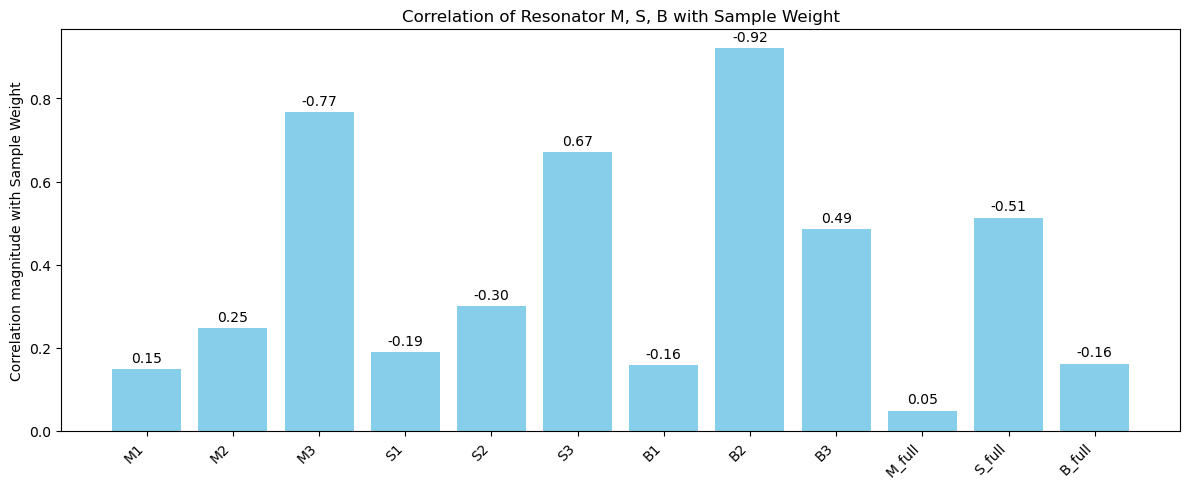

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

n_res = len(fs_cols)  # number of resonators
M_cols, S_cols, B_cols = [], [], []

for i in range(n_res):
    fs = df[f"fs{i+1}"].values
    Q = df[f"Q{i+1}"].values
    Cm = df[f"Cm{i+1}"].values
    
    # Motional mass
    M = 1 / ((2 * np.pi * fs)**2 * Cm)
    df[f"M{i+1}"] = M
    M_cols.append(f"M{i+1}")
    
    # Motional spring
    S = 1 / Cm
    df[f"S{i+1}"] = S
    S_cols.append(f"S{i+1}")
    
    # Damping / friction
    B = fs / (Q * Cm)
    df[f"B{i+1}"] = B
    B_cols.append(f"B{i+1}")

# Full system averages
df["M_full"] = df[M_cols].mean(axis=1)
df["S_full"] = df[S_cols].mean(axis=1)
df["B_full"] = df[B_cols].mean(axis=1)

equiv_cols = M_cols + S_cols + B_cols + ["M_full","S_full","B_full"]

# Compute correlations
corr_values = []
corr_signs = []
for col in equiv_cols:
    corr, _ = pearsonr(df[col], sample_weights_filtered)
    corr_values.append(abs(corr))
    corr_signs.append("-" if corr < 0 else "")

# Bar plot
plt.figure(figsize=(12,5))
bars = plt.bar(equiv_cols, corr_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation magnitude with Sample Weight')
plt.title('Correlation of Resonator M, S, B with Sample Weight')

# Add labels with minus for negative correlations
for bar, corr, sign in zip(bars, corr_values, corr_signs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{sign}{corr:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
